In [181]:
import time
import os         
from bs4 import BeautifulSoup  
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [182]:

def get_100_books_to_arr(url):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
    books_links=[]
    r = requests.get(url, headers=headers)
    data = r.text
    books_soup = BeautifulSoup(data)
    for book in books_soup.find_all("tr"):
        new_link="https://www.goodreads.com/"+book.select('tr > td')[2].a["href"]
        books_links.append(new_link)
    return books_links

def get_next_page_url(page_number):
    main_url = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page="
    new_page_url = main_url + str(page_number)
    return new_page_url
   
def get_Dataframe_of_100_rows(url, books_links):

    book_url_page=[]
    name = []
    rating_num = [] 
    user_rating = []
    num_page = []     
    year = []
    reviews = []      
    author = []
    publisher = []
    language = []
    genre_1 = []
    genre_2 = []
    genre_3 = []
    for book_page in books_links:
        book_url_page.append(book_page)      
        attemps = 0
        while (attemps <5):
            try:
                headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36 Edg/96.0.1054.62"}
                r = requests.get(book_page, headers=headers)
                soup = BeautifulSoup(r.content, "html.parser")
                try:
                    name.append(soup.find('h1',attrs={"data-testid": "bookTitle"}).get_text().strip())
                except:
                    name.append(np.nan)
                try:
                    author.append(soup.find('span',attrs = {"class":"ContributorLink__name"}).get_text())
                except:
                    author.append(np.nan)
                try:
                    num_page.append(soup.find('p',attrs = {"data-testid":"pagesFormat"}).get_text().split("pages")[0].strip())
                except:
                    num_page.append(np.nan)
                try:
                    script_tag = soup.find('script', {'type': 'application/ld+json'})
                    json_script = script_tag.string

                    start_index = json_script.find('"inLanguage":"') + len('"inLanguage":"')
                    end_index = json_script.find('"', start_index)
                    in_language = json_script[start_index:end_index]
                    language.append(in_language)
                except:
                    language.append(np.nan)
                try:
                    user_rating.append(soup.find('div',attrs = {"class":"RatingStatistics__rating"}).get_text().strip())
                except:
                    user_rating.append(np.nan)
                try:
                    rating_num.append(soup.find('span',attrs = {"data-testid":"ratingsCount"}).get_text().split("ratings")[0].strip())
                except:
                    rating_num.append(np.nan)
                try:
                    reviews.append(soup.find('span',attrs = {"data-testid":"reviewsCount"}).get_text().split("reviews")[0].strip())
                except:
                    reviews.append(np.nan)
                try:
                    genre_1.append(soup.find_all('span',attrs = {"class":"BookPageMetadataSection__genreButton"})[0].get_text())
                except:
                    genre_1.append(np.nan)
                try:
                    genre_2.append(soup.find_all('span',attrs = {"class":"BookPageMetadataSection__genreButton"})[1].get_text())
                except:
                    genre_2.append(np.nan)
                try:
                    genre_3.append(soup.find_all('span',attrs = {"class":"BookPageMetadataSection__genreButton"})[2].get_text())
                except:
                    genre_3.append(np.nan)
                try:
                    val = soup.find('p',attrs = {"data-testid":"publicationInfo"}).get_text().split()[4]
                    if int(val) > 35:
                        year.append(val)
                    else:
                        year.append(np.nan) 
                except:
                    year.append(np.nan) 
                try:
                    script_tag = soup.find('script', {'type': 'application/json'})
                    json_script = script_tag.string

                    start_index = json_script.find('"publisher":"') + len('"publisher":"')
                    end_index = json_script.find('"', start_index)
                    in_language = json_script[start_index:end_index]
                    publisher.append(in_language)
                
                except:
                    publisher.append(np.nan)
                break 
            except:
                attemps += 1
                
        if (attemps == 5):
            name.append(np.nan)
            author.append(book_page)
            num_page.append(np.nan)
            language.append(np.nan)
            user_rating.append(np.nan)
            rating_num.append(np.nan)
            reviews.append(np.nan)  
            genre_1.append(np.nan)
            genre_2.append(np.nan)
            genre_3.append(np.nan) 
            year.append(np.nan)
            publisher.append(np.nan)
        sleep(round(random.uniform(1, 1.75), 2)) #Get random sleep time
    df = pd.DataFrame({'name':name,'author':author,'num_page':num_page,'language':language,'user_rating':user_rating,'rating_num':rating_num,'reviews':reviews, 'genre_1':genre_1,'genre_2':genre_2,'genre_3':genre_3,'year':year,'publisher':publisher,'book_url': book_url_page})
    
    return df

def sleep(sec):
    time.sleep(sec)

def create_complete_DataFrame(num_of_pages):
    column_names = ["name", "author", "num_page","language","user_rating","rating_num","reviews","genre_1","genre_2","genre_3","year","publisher","book_url"]
    if os.path.isfile('df_1.csv') and os.path.getsize('df_1.csv') > 0:
        df = pd.read_csv('df_1.csv')
    else:
        df = pd.DataFrame(columns = column_names)
    num_page_to_start = int(len(df.index)/100)
    for index in range(num_page_to_start, num_page_to_start + num_of_pages - 1):
        Nth_page_url = get_next_page_url(index+1) 
        books_links_per_page_list = get_100_books_to_arr(Nth_page_url)
        new_df = get_Dataframe_of_100_rows(Nth_page_url,books_links_per_page_list)
        df = pd.concat([df, new_df],ignore_index=True)
        print("done ",index)
        sleep(3)
        df.to_csv('df_1.csv')
        sleep(random.randint(20, 57))
    return df    

In [81]:
# df = create_complete_DataFrame(100)


In [183]:
def remove_non_numbers(string):
    numbers_only = ''.join(char for char in string if char.isdigit() or char =='.' or char == ',')
    return numbers_only
    
def convert_string_to_num(df,columns_to_convert):
    for column in columns_to_convert:
        df[column] = df[column].str.replace(r'[^0-9.,]', '', regex=True)
        df[column] = pd.to_numeric(df[column])
            

def data_clean(df,columns_to_drop):
    result = df.copy()
    result.drop_duplicates()
    result = result[result['num_page'].astype(str).str.isnumeric()]
    result['rating_num'] = result['rating_num'].str.replace(',', '')
    result['reviews'] = result['reviews'].str.replace(r'[, review]', '', regex=True)
    result['language'].fillna(result['language'].mode()[0], inplace=True)
    result['publisher'].fillna(result['publisher'].mode()[0], inplace=True)
    result['genre_1'].fillna(result['genre_1'].mode()[0], inplace=True)
    result['genre_2'].fillna(result['genre_2'].mode()[0], inplace=True)
    result['genre_3'].fillna(result['genre_3'].mode()[0], inplace=True)
    result['reviews'].fillna(result['reviews'].median(), inplace=True)
    result['num_page'].fillna(result['num_page'].median(), inplace=True)
    result['year'].fillna(result['year'].median(), inplace=True)
    for index,row in result.iterrows():
        if(pd.isnull(row['name'])):
            result.drop([index],axis = 0,inplace = True)
    if(len(columns_to_drop)):
        result.drop(labels =columns_to_drop ,axis = 1, inplace = True) 
    convert_string_to_num(result,['rating_num','reviews','num_page'])
    result = result[~result['language'].str.startswith('https')]
    result['year'] = result['year'].astype(int)
    result.to_csv("Final_1.csv")
    return result

In [184]:
df = pd.read_csv("df_1.csv")
df.columns = df.columns.str.lower()
result = data_clean(df,columns_to_drop=['unnamed: 0.2', 'unnamed: 0.1', 'unnamed: 0','book_url'])
df = result
df.to_csv("Final_1.csv")


In [185]:
df

,name,author,num_page,language,user_rating,rating_num,reviews,genre_1,genre_2,genre_3,year,publisher
0,The Hunger Games,Suzanne Collins,374,English,4.33,7999679,198171,Young Adult,Fiction,Dystopia,2008,Scholastic Press
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,912,English,4.50,3160046,57494,Fantasy,Young Adult,Fiction,2003,Scholastic Inc.
2,Pride and Prejudice,Jane Austen,279,English,4.28,3961700,101281,Classics,Fiction,Romance,1813,Modern Library
3,To Kill a Mockingbird,Harper Lee,323,English,4.27,5714197,110728,Classics,Fiction,Historical Fiction,1960,Harper Perennial Modern Classics
4,The Book Thief,Markus Zusak,552,English,4.39,2375178,136571,Historical Fiction,Fiction,Young Adult,2006,Alfred A. Knopf
...,...,...,...,...,...,...,...,...,...,...,...,...
10194,When Genius Failed: The Rise and Fall of Long-...,Roger Lowenstein,264,English,4.20,27857,874,Finance,Business,Nonfiction,2000,Random House Trade Paperbacks
10195,Pies & Prejudice,Heather Vogel Frederick,378,English,4.36,6298,475,Middle Grade,Young Adult,Contemporary,2010,Simon \u0026 Schuster Books for Young Readers
10196,The Yellow Birds,Kevin Powers,226,English,3.74,25082,3436,Fiction,War,Historical Fiction,2012,"Little, Brown and Company"
10197,Burn,Maya Banks,353,English,3.99,43293,2128,Romance,Erotica,BDSM,2013,Berkley


<AxesSubplot:xlabel='Genres', ylabel='Rating'>

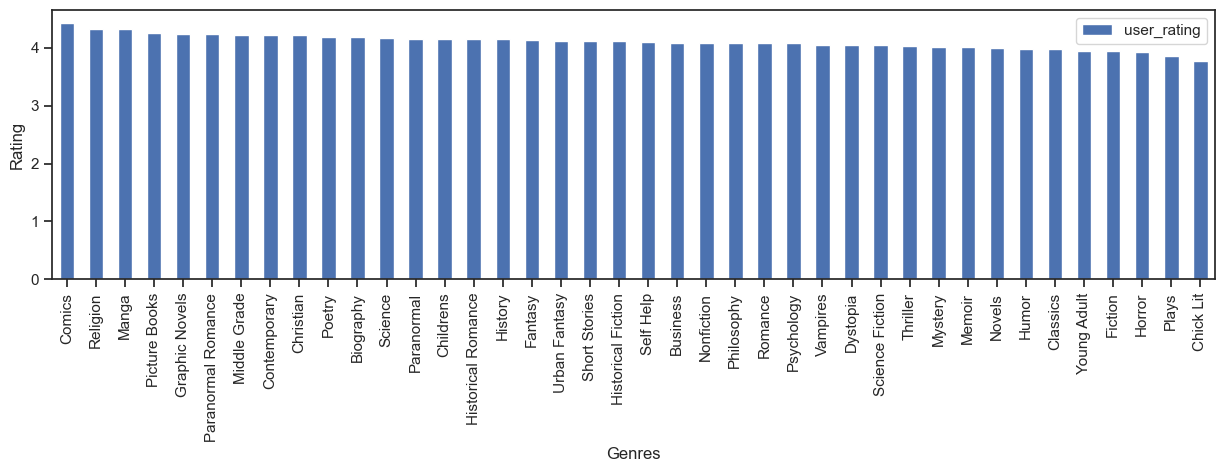

In [186]:

average_ratings_df = df.groupby('genre_1')['user_rating'].mean().reset_index()
top_40_genres = df['genre_1'].value_counts()[0:40].index
average_ratings_top_40 = average_ratings_df[average_ratings_df['genre_1'].isin(top_40_genres)]

xy = pd.DataFrame(average_ratings_top_40.sort_values(['user_rating'],ascending=False))
xy.set_index('genre_1', inplace=True)

xy.drop_duplicates(inplace=True)
xy.plot(kind = 'bar',xlabel ="Genres",ylabel="Rating",figsize=(15,3.5))

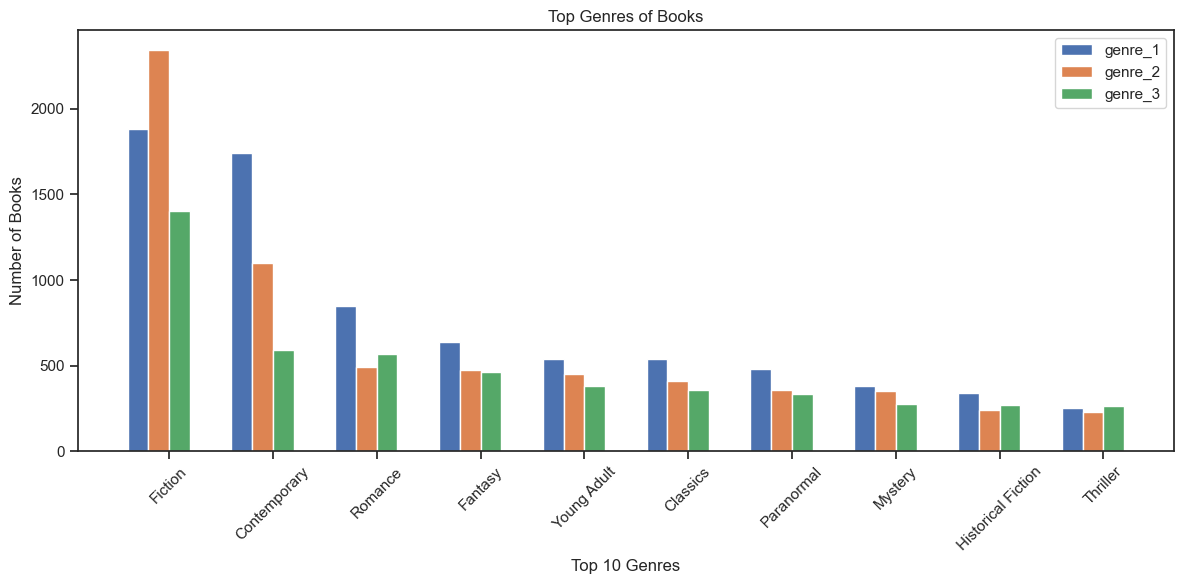

In [187]:
genre_columns = ['genre_1', 'genre_2', 'genre_3']
num_top_genres = 10 
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(num_top_genres)
bar_width = 0.2

for i, column in enumerate(genre_columns):
    genre_counts = df[column].value_counts().head(num_top_genres)
    genre_names = genre_counts.index
    genre_values = genre_counts.values

    ax.bar(index + i * bar_width, genre_values, bar_width, label=column)

ax.set_xlabel('Top 10 Genres')
ax.set_ylabel('Number of Books')
ax.set_title('Top Genres of Books')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(genre_names, rotation=45)
ax.legend()

plt.tight_layout() 

plt.show()

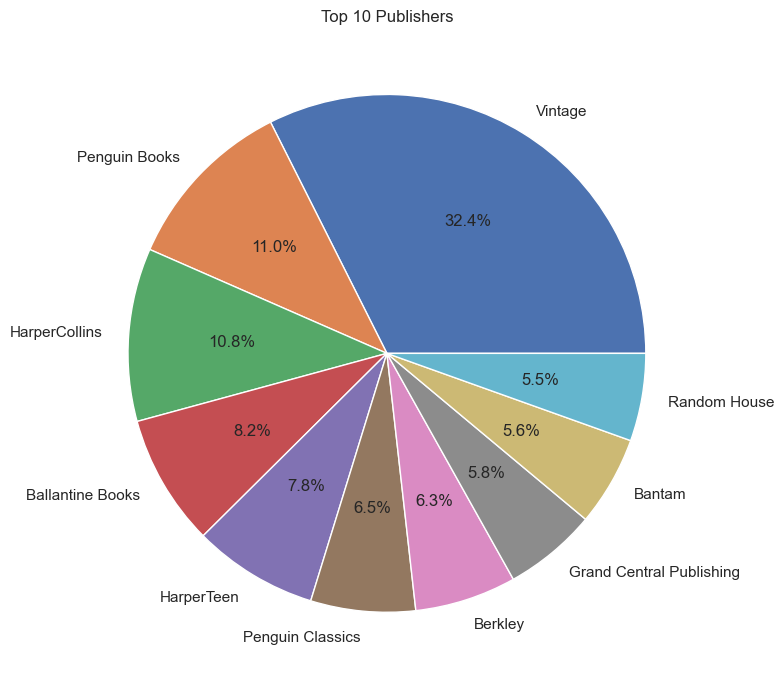

In [188]:
# Pie Plot top 10 publishers
num_top_publisher = 10
publisher_counts = df['publisher'].value_counts()
top_publisher_names = publisher_counts.index[:num_top_publisher]
publisher_counts = df[df['publisher'].isin(top_publisher_names)]['publisher'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(publisher_counts, labels=top_publisher_names, autopct='%1.1f%%')

ax.set_title("Top 10 Publishers")
plt.tight_layout() 
plt.show()

C:\Users\koren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


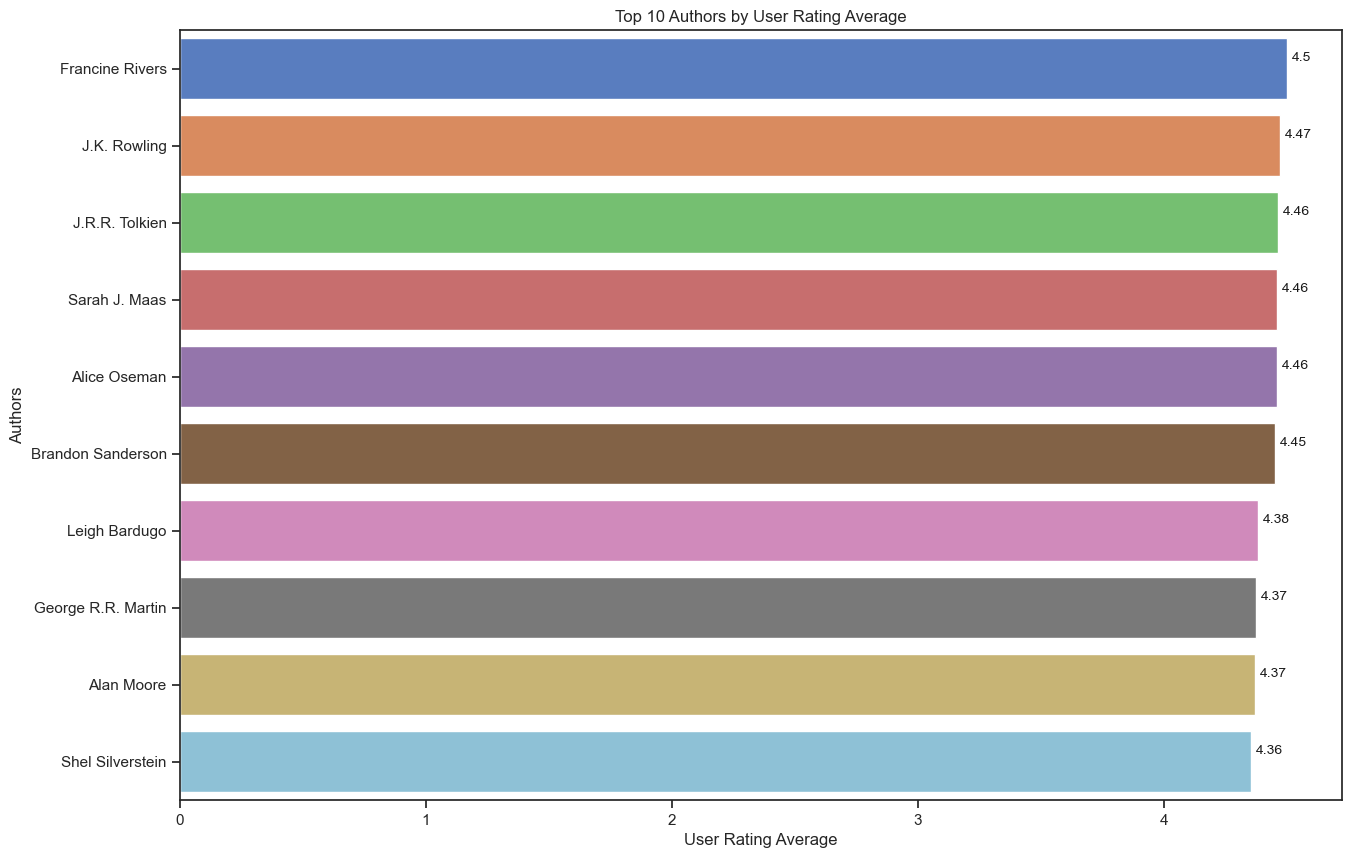

In [189]:
author_counts = df['author'].value_counts()
top_10_authors = df[df['user_rating'] >= 4]
top_10_authors = top_10_authors[top_10_authors['reviews'] >= 10000]
top_10_authors = top_10_authors[top_10_authors['author'].map(author_counts) > 5]
top_10_authors = top_10_authors.groupby('author')['user_rating'].mean().reset_index().sort_values('user_rating', ascending=False).head(10).set_index('author')

sns.set_style("ticks")

plt.figure(figsize=(15, 10))

ax = sns.barplot(top_10_authors['user_rating'], top_10_authors.index, palette='muted')
ax.set_xlabel("User Rating Average")
ax.set_ylabel("Authors")
ax.set_title('Top 10 Authors by User Rating Average')

for i in ax.patches:
    ax.text(i.get_width() + 0.02, i.get_y() + 0.3, str(round(i.get_width(), 2)), fontsize=10, color='k')

plt.show()

9687


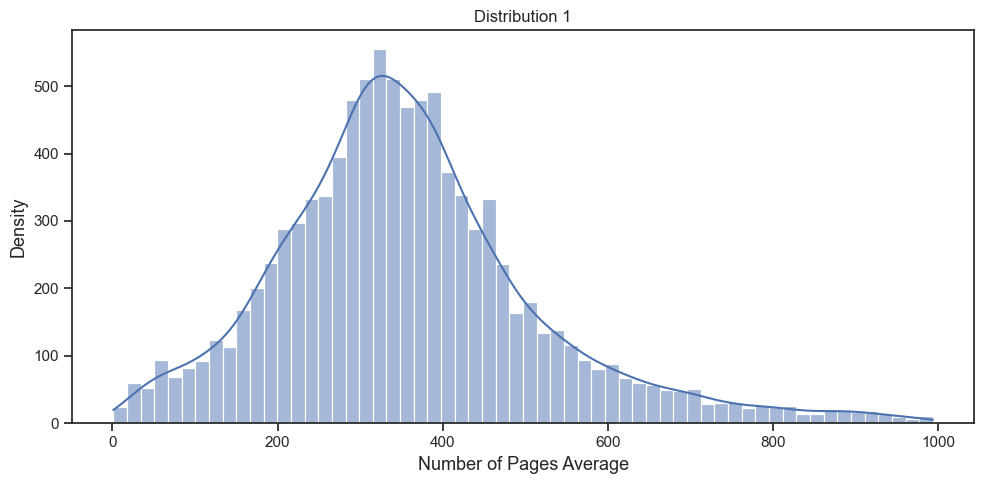

In [190]:
dist = df[~(df['num_page']>1000)]
print(len(dist))
fig, ax = plt.subplots(figsize=[10, 5])

sns.histplot(dist['num_page'], kde=True, ax=ax)
ax.set_title("Distribution 1")
ax.set_xlabel('Number of Pages Average',fontsize=13)
ax.set_ylabel("Density",fontsize=13)

plt.tight_layout()

plt.show()

<Figure size 1500x1000 with 0 Axes>

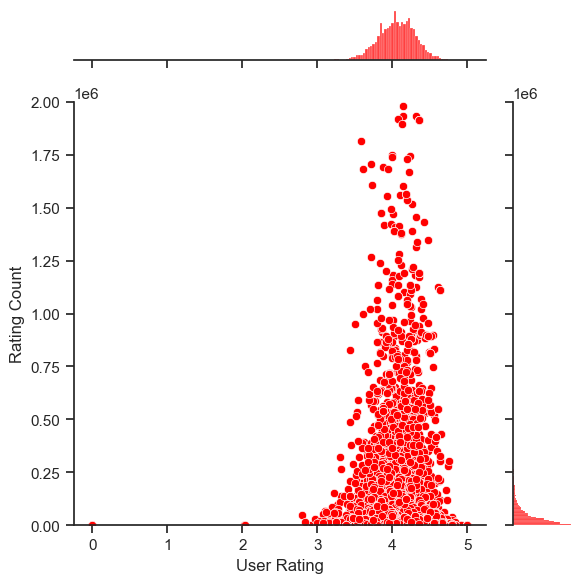

In [195]:
plt.figure(figsize=(15,10))
jointplot = sns.jointplot(data=df, x='user_rating',y='rating_num', kind='scatter',ylim=(0,2000000),color = 'red')
jointplot.set_axis_labels('User Rating', 'Rating Count')
plt.tight_layout()

plt.show()
# user_rating / rating_num

<Figure size 1500x1000 with 0 Axes>

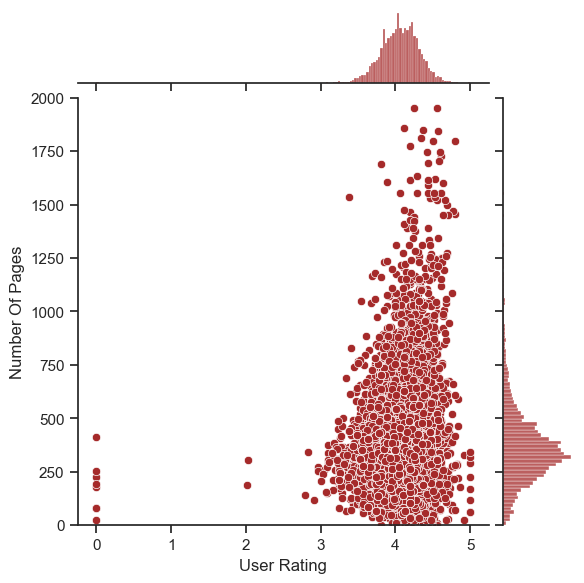

In [193]:
plt.figure(figsize=(15,10))
jointplot = sns.jointplot(data=df, x='user_rating',y='num_page', kind='scatter',ylim=(0,2000),color = 'brown')
jointplot.set_axis_labels('User Rating', 'Number Of Pages')

plt.show()

<Figure size 1500x1000 with 0 Axes>

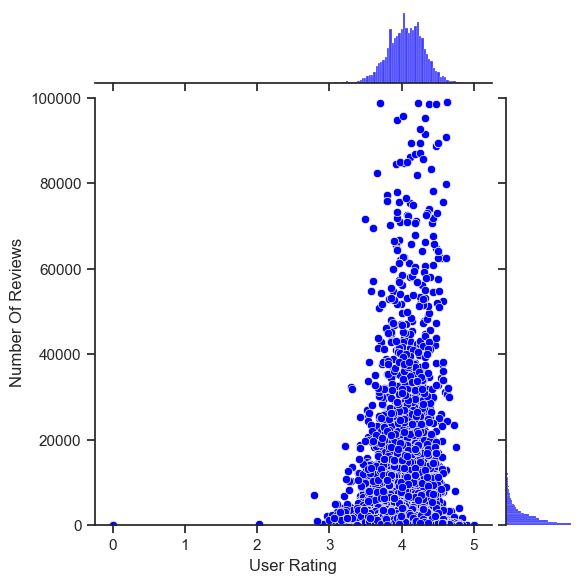

In [194]:
plt.figure(figsize=(15,10))
jointplot = sns.jointplot(data=df, x='user_rating',y='reviews', kind='scatter',ylim=(0,100000),color = 'blue')
jointplot.set_axis_labels('User Rating', 'Number Of Reviews')
# user_rating / reviews
plt.show()


In [202]:

df_ml = df[df['rating_num'] > 30000]
df_ml.dropna(inplace=True)

X = df_ml.drop('user_rating', axis=1)
y = df_ml['user_rating']
categorical_columns = ['name', 'author', 'language', 'genre_1', 'genre_2', 'genre_3', 'publisher']
label_encoder = LabelEncoder()
X_encoded = X.copy()
for column in categorical_columns:
    X_encoded[column] = label_encoder.fit_transform(X[column])

numerical_columns = ['num_page', 'rating_num', 'reviews', 'year']
scaler = StandardScaler()
X_encoded[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=10)


regressor = LinearRegression()
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
actual = pd.DataFrame({'Actual User Rating': y_test})
predicted = pd.DataFrame({'Predicted User Rating': predictions})
actual.reset_index(drop=True, inplace=True)
predicted.reset_index(drop=True, inplace=True)
result = pd.concat([actual, predicted], axis=1)
print(result)

      Actual User Rating  Predicted User Rating
0                   4.61               4.154337
1                   4.04               4.049549
2                   4.16               4.049275
3                   3.78               4.038944
4                   4.22               4.049002
...                  ...                    ...
1050                3.97               3.993296
1051                4.33               4.007311
1052                4.26               4.062720
1053                3.99               4.051202
1054                4.17               4.040484

[1055 rows x 2 columns]


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6640\3577414970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml.dropna(inplace=True)


In [203]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.17506103378365973
MSE: 0.04769796262962092
RMSE: 0.21839863238953883


<AxesSubplot:>

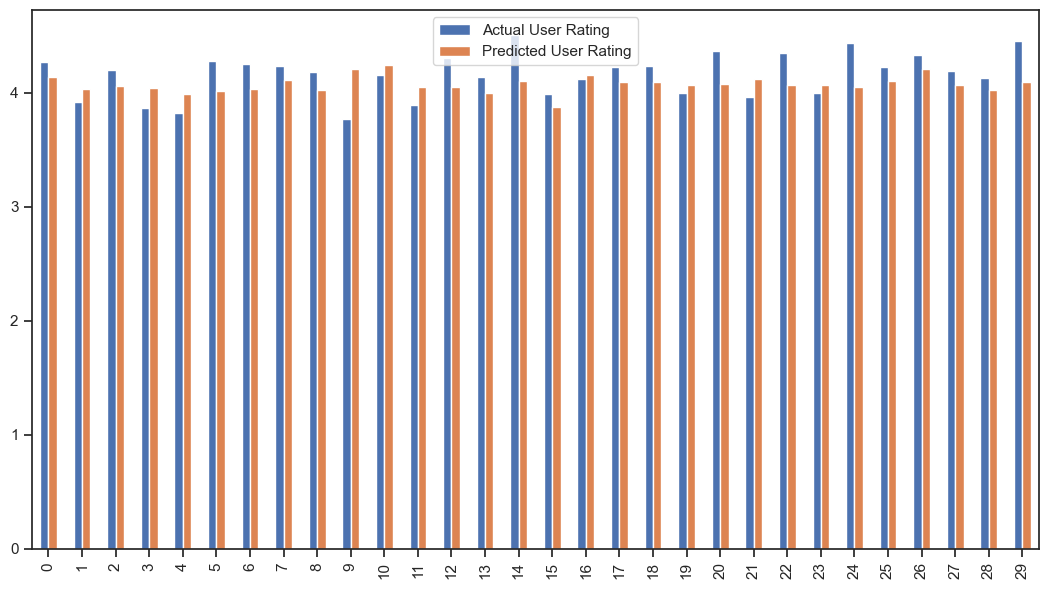

In [ ]:
predicted_30 = result.head(30)
predicted_30.plot(kind='bar', figsize=(13, 7))


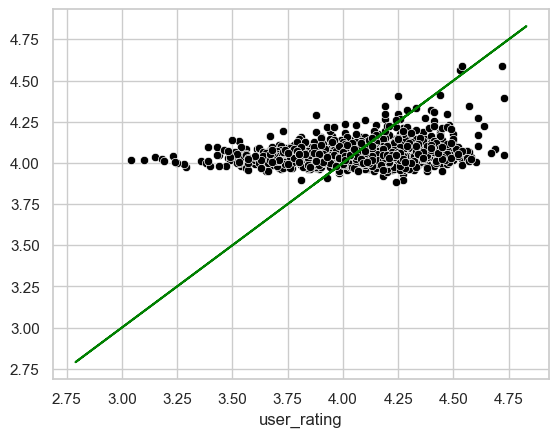

In [ ]:
ax = sns.scatterplot(x=y_test, y=predictions,color='black')
ax.plot(y_train, y_train, 'green')